# HA 3 - Gaussian Processes

In [1]:
# !pip show pymc
!pip install -U pymc>=5.9 numpyro

In [4]:
#!g1.1
import arviz as az
import pandas as pd
import json
import numpy as np
import pymc as pm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here is RLMS dataset fraction for sports activities questions. The questionare is very involved and looks like this.
https://www.hse.ru/data/2022/05/25/1814514241/R30_A_for%20users.pdf

After reading SPSS dataset I stored the fraction in a csv file `rlms_sport.csv` and the complimentary metadata in `meta.json`. You can use the following code to load the data and get understanding about the content.

## Why Bayes
* Tight estimates for variable outcomes: close ages contribute
* Interpolation for missing responces, imbalanced data

In [5]:
#!g1.1
warnings.filterwarnings('ignore')

rlms = (
    pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rlms_sport.csv', index_col=0)
    # convert encoded nans to nan
    .replace({99999997.0: np.nan, 99999998.0: np.nan, 99999999.0: np.nan,})
    # for other variables refer to meta["labels"]
)

meta = json.load(open('/content/drive/MyDrive/Colab Notebooks/meta.json'))

In [6]:
#!g1.1
meta['columns']

{'redid_i': 'НОМЕР ИНДИВИДА - СПЛОШНАЯ НУМЕРАЦИЯ',
 'int_y': 'ГОД ПРОВЕДЕНИЯ ИНТЕРВЬЮ',
 'h5': 'Пол респондента',
 'h6': 'Год рождения респондента (=J69.9C)',
 'age': 'Количество полных лет',
 'm1131aa': 'Вы занимались в течение последних 12 месяцев по меньшей мере 12 раз бегом трусцой, плаванием?',
 'm1131ab': 'Сколько месяцев за последний год Вы занимались бегом трусцой, плаванием?',
 'm1131ac': 'Сколько раз в месяц Вы занимались бегом трусцой, плаванием?',
 'm1131ad': 'Сколько минут продолжалось каждое занятие бегом трусцой, плаванием?',
 'm113.1a': 'Вы занимались в течение последних 12 месяцев по меньшей мере 12 раз бегом трусцой?',
 'm113.1b': 'Сколько месяцев за последний год Вы занимались бегом трусцой, катанием на коньках, лыжах?',
 'm113.1c': 'Сколько раз в месяц Вы занимались бегом трусцой, катанием на коньках, лыжах?',
 'm113.1d': 'Сколько минут продолжалось каждое занятие бегом трусцой, катанием на коньках, лыжах?',
 'm11311a': 'Вы занимались в течение последних 12 месяцев 

In [7]:
#!g1.1
meta['labels']

{'redid_i': None,
 'int_y': None,
 'h5': {'1.0': 'МУЖСКОЙ', '2.0': 'ЖЕНСКИЙ'},
 'h6': {'99999997.0': 'ЗАТРУДНЯЮСЬ ОТВЕТИТЬ',
  '99999998.0': 'ОТКАЗ ОТ ОТВЕТА',
  '99999999.0': 'НЕТ ОТВЕТА'},
 'age': {'99999997.0': 'ЗАТРУДНЯЮСЬ ОТВЕТИТЬ',
  '99999998.0': 'ОТКАЗ ОТ ОТВЕТА',
  '99999999.0': 'НЕТ ОТВЕТА'},
 'm1131aa': {'1.0': 'Да',
  '2.0': 'Нет',
  '99999997.0': 'ЗАТРУДНЯЮСЬ ОТВЕТИТЬ',
  '99999998.0': 'ОТКАЗ ОТ ОТВЕТА',
  '99999999.0': 'НЕТ ОТВЕТА'},
 'm1131ab': {'99999997.0': 'ЗАТРУДНЯЮСЬ ОТВЕТИТЬ',
  '99999998.0': 'ОТКАЗ ОТ ОТВЕТА',
  '99999999.0': 'НЕТ ОТВЕТА'},
 'm1131ac': {'99999997.0': 'ЗАТРУДНЯЮСЬ ОТВЕТИТЬ',
  '99999998.0': 'ОТКАЗ ОТ ОТВЕТА',
  '99999999.0': 'НЕТ ОТВЕТА'},
 'm1131ad': {'99999997.0': 'ЗАТРУДНЯЮСЬ ОТВЕТИТЬ',
  '99999998.0': 'ОТКАЗ ОТ ОТВЕТА',
  '99999999.0': 'НЕТ ОТВЕТА'},
 'm113.1a': {'1.0': 'Да',
  '2.0': 'Нет',
  '99999997.0': 'ЗАТРУДНЯЮСЬ ОТВЕТИТЬ',
  '99999998.0': 'ОТКАЗ ОТ ОТВЕТА',
  '99999999.0': 'НЕТ ОТВЕТА'},
 'm113.1b': {'99999997.0': 'ЗАТРУДНЯЮСЬ ОТВЕТИТЬ'

## 1. Prepare your data
Choose any activity you like to study. It could be
1. **A binary Yes/No (r in [0, 1]) for questions like "Вы занимались в течение...?"**
2. A fraction (f in 0-1) for questions like  "Сколько месяцев за последний год...?" (divide the number by 12)
3. An integer (n>=0) for questions like "Сколько раз в месяц...?"

> * 1 is the default choice, the easiest one
> * If you choose 2 or 3, we will multiply your points by 1.5, so maxumum is 60pt instead of 40pt
> * The last independent bonus is 5pt, but maximum is still 60pt


### 1.1 Make your choice
Save the variable name to `MY_SPORT=...`

In [8]:
#!g1.1
MY_SPORT = 'm113.4a' # баскетбол, волейбол, футбол, хоккей

### Prepare data variables for the model (5pt)
1. Drop irrelevant columns, `mysport` variable
2. Make sure there are no nans left for age and the `MY_SPORT`
3. Create a grid for all possible ages in the dataframe, `ages_between` variable
4. Create a scatterplot for the outcome variable `MY_SPORT ~ age`
### Build the model (35pt)
1. Model definition as in the Latex desctiption (10pt)
2. Prior Predictive check to choose `?` (15pt)
3. Sampling and posterior vs prior plots `az.plot_dist_comparison` (5pt+5pt)
4. Divergences coefficient apply for the above 10pt only (50% divergences = loose 5pt from 3.)

> Hacks to gain points
> * Submit anything regardless
> * Data preparation is easy but wights something
> * Translate the latex to python with any priors = points
> * The juice is prior predictive, it weights the most
> * Choosing bonus model boosts your points. Do it if you need it.
> * Use helper functions, ask questions

In [9]:
features = ['redid_i', 'int_y', 'h5', 'h6', 'age', MY_SPORT]

mysport = rlms.loc[(~rlms[MY_SPORT].isna()) & (~rlms['age'].isna()), features]
mysport[MY_SPORT] = mysport[MY_SPORT].map({1.0: 1, 2.0: 0}) # '1.0': 'Да', '2.0': 'Нет'
ages_between = mysport.age.drop_duplicates().sort_values().to_numpy()

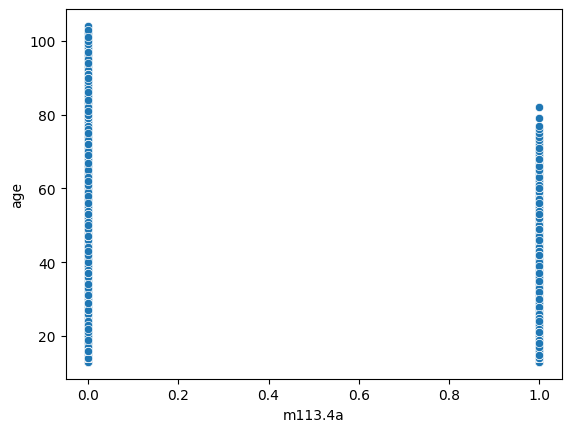

In [10]:
sns.scatterplot(data=mysport, x=MY_SPORT, y='age')
plt.show()

In [11]:
#!g1.1
assert isinstance(mysport, pd.DataFrame)
assert not mysport[MY_SPORT].isna().any()
assert not mysport.age.isna().any()
assert mysport.age.isin(ages_between).all()

## 2 Bayesian Model setup

Here are plotting functions you should find useful to make cool plots from the posterior/prior

In [12]:
#!g1.1
import seaborn as sns
def plot_quantile(posterior, variable):
    m = posterior[variable].median(["chain", "draw"])
    s05 = posterior[variable].quantile([0.05, 0.95], ["chain", "draw"])
    s25 = posterior[variable].quantile([0.25, 0.75], ["chain", "draw"])
    ages = m.coords["age"]
    plt.plot(ages, m, color="b");
    plt.fill_between(ages, *s05.values, alpha=0.5, color="b");
    plt.fill_between(ages, *s25.values, alpha=0.5, color="b");
    return plt.gca()


def plot_histogram2d(posterior, variable):
    x, y = map(
        np.ndarray.flatten,
        np.broadcast_arrays(
            posterior.coords["age"],
            posterior[variable].stack(sample=["chain", "draw"]).values.T)
    )
    sns.histplot(x="age", y=variable, data={"age": x, variable: y});
    return plt.gca()

## Model variant 1

I've prepared a Bayesian model that just works for the such kind of problems. You should implement the one that fits your case

### Binary outcome model
$$
\begin{align}
    k_a &\sim \operatorname{Binomial}(n_a, p_a)\\
    p_a & = \operatorname{sigmoid}(\tilde p_a)\\
    \tilde p_a &\sim \mathcal{GP}(\mu_{const}, K(.,.))\\
    K(.,.)&=\operatorname{cov.Exponential}(\operatorname{ls}=l) \cdot \alpha\\
    l&\sim \operatorname{Gamma}(?, ?)\\
    \alpha&\sim \operatorname{Exponential}(?)\\
    \mu_{const} &\sim \operatorname{Normal}(?, ?)
\end{align}
$$

## Model variant 1 (bonus 50%)
Instead of aggregation for the binary model, you will need histogram approximation.

### Fractional outcome model
A slightly modified version of the likelihood above

* The difference is that there are now 2 GPs in one model

$$
\begin{align}
    f_a &\sim \operatorname{LogitNormal}(\tilde p_a, \sigma_a)\\
    \text{mean} & \quad\mathcal{GP}\\
    \tilde p_a &\sim \mathcal{GP}(\mu_{const}, K_\mu(.,.))\\
    K_\mu(.,.)&=\operatorname{cov.Exponential}(\operatorname{ls}=l_\mu) \cdot \alpha_\mu\\
    l_\mu&\sim \operatorname{Gamma}(?, ?)\\
    \alpha_\mu&\sim \operatorname{Exponential}(?)\\
    \mu_{const} &\sim \operatorname{Normal}(?, ?)\\
    \color{blue}{\text{sd}}&\color{blue}{\quad\mathcal{GP}}\\
    \sigma_a & = \exp(\sigma_a)\\
    \tilde \sigma_a &\sim \mathcal{GP}(\mu_{\sigma}, K_\sigma(.,.))\\
    K_\sigma(.,.)&=\operatorname{cov.Exponential}(\operatorname{ls}=l_\sigma) \cdot \alpha_\sigma\\
    l_\sigma&\sim \operatorname{Gamma}(?, ?)\\
    \alpha_\sigma&\sim \operatorname{Exponential}(?)\\
    \mu_\sigma &\sim \operatorname{Normal}(?, ?)
\end{align}
$$

### Count outcome model
A slightly modified version of the likelihood above (Zero Inflated)

* Assign zeros to observations what said they did not do activities (were No for the non-bonus model)

$$
\begin{align}
    c_a &\sim \operatorname{ZeroInflatedPoisson}(p_a, \lambda_a)\\
    \color{blue}{\text{zero inflation}} &\color{blue}{\quad\mathcal{GP}}\\
    p_a & = \operatorname{sigmoid}(\tilde p_a)\\
    \tilde p_a &\sim \mathcal{GP}(\mu_{const}, K_\mu(.,.))\\
    K_\mu(.,.)&=\operatorname{cov.Exponential}(\operatorname{ls}=l_\mu) \cdot \alpha_\mu\\
    l_\mu&\sim \operatorname{Gamma}(?, ?)\\
    \alpha_\mu&\sim \operatorname{Exponential}(?)\\
    \mu_{const} &\sim \operatorname{Normal}(?, ?)\\
    \color{blue}{\text{mean}}&\color{blue}{\quad\mathcal{GP}}\\
    \lambda_a & = \exp(\tilde \lambda_a)\\
    \tilde \lambda_a &\sim \mathcal{GP}(\mu_{\lambda}, K_\lambda(.,.))\\
    K_\lambda(.,.)&=\operatorname{cov.Exponential}(\operatorname{ls}=l_\lambda) \cdot \alpha_\lambda\\
    l_\lambda&\sim \operatorname{Gamma}(?, ?)\\
    \alpha_\lambda&\sim \operatorname{Exponential}(?)\\
    \mu_\lambda &\sim \operatorname{Normal}(?, ?)
\end{align}
$$

1. For binomial likelihood you will find it usefull to aggregate data.
    * Use `df.groupby(...).count()`, `df.groupby(...).sum()`
2. For slicing `p_a` from the `GP` you can use indexing.
    * Construct index using `np.searchsorted` from the above output
3. Adjust the priors using prior predictive checks.
    * Use `plot_quantile(trace.prior)`
    * Use `plot_histogram2d(trace.prior)`
    * For bonus models, only visualize the parameters of the likelihood, e.g. $p_a$, $\lambda_a$, $\sigma_a$
    * Make sure you get expectd results
4. For bonus models use the helper function below
    * compute histogram of unique values
    * create a potential as in [pmx](https://github.com/pymc-devs/pymc-experimental/blob/main/pymc_experimental/distributions/histogram_utils.py#L158)
    * with "age" output of the helper function if will be easy to take slices from GP, use `np.searchsorted`
    * yeah, that's why it is bonus
5. On any questions or help request, contact your Lecturer

In [13]:
#!g1.1
def histogram_from_groupby(data, variable, grouping='age'):
    assert ~data[variable].isna().any(), 'has nans'
    value_counts = (
        data
        .groupby(grouping)
        [variable]
        .apply(lambda x: np.unique(x, return_counts=True))
    )
    mid, count = map(np.concatenate, zip(*value_counts))
    ages_bins = np.repeat(value_counts.index, value_counts.apply(lambda x: len(x[0])))
    return dict(age=ages_bins, mid=mid, count=count)

In [14]:
a = ages_between - ages_between.mean()
a = a[a > 0]
m = [np.ceil(1.75 * 1.25 / np.quantile(a, 0.05))]
L = [45.5 * 1.2]

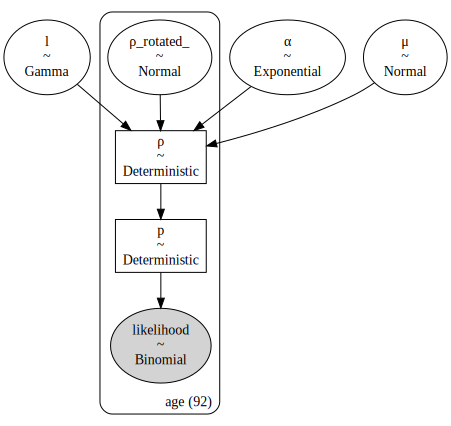

In [93]:
#!g1.1
# Model definition as in the Latex desctiption (10pt)
with pm.Model(coords={'age': ages_between}) as model:
    l = pm.Gamma(name='l', mu=15, sigma=1)
    α = pm.Exponential(name='α', lam=1.)
    K = pm.gp.cov.Exponential(input_dim=1, ls=l) * α
    μ = pm.gp.mean.Constant(pm.Normal(name='μ', mu=-4, sigma=1))

    GP = pm.gp.Latent(mean_func=μ, cov_func=K)

    ρ = GP.prior(name='ρ', X=ages_between[:, None], dims='age')
    p = pm.Deterministic(name='p', var=pm.math.sigmoid(ρ), dims='age')

    likelihood = pm.Binomial(
        name='likelihood',
        n=mysport.groupby('age')[MY_SPORT].count(),
        p=p,
        observed=mysport.groupby('age')[MY_SPORT].sum(),
        dims='age',
    )
pm.model_to_graphviz(model)

\begin{array}{rcl}
            \text{l} &\sim & \operatorname{Gamma}(5, 1)\\\text{α} &\sim & \operatorname{Exponential}(10)\\\text{μ} &\sim & \operatorname{Normal}(0,~1.5)\\\text{ρ_rotated_} &\sim & \operatorname{Normal}(0,~1)\\\text{ρ} &\sim & \operatorname{Deterministic}(f(\text{ρ_rotated_},~\text{μ},~\text{α},~\text{l}))\\\text{p} &\sim & \operatorname{Deterministic}(f(\text{ρ_rotated_},~\text{μ},~\text{α},~\text{l}))\\\text{likelihood} &\sim & \operatorname{Binomial}(\text{<constant>},~\text{p})
            \end{array}

In [94]:
#!g1.1
import pymc.sampling_jax

# Divergences coefficient apply for the above 10pt only (50% divergences = loose 5pt from 3.)
with model:
    trace = pymc.sampling_jax.sample_numpyro_nuts(chains=4, draws=1000, tune=1000, chain_method='vectorized', postprocessing_backend='gpu')
    trace.extend(pm.sample_posterior_predictive(trace))
    trace.extend(pm.sample_prior_predictive())

trace.to_netcdf('/content/drive/MyDrive/Colab Notebooks/trace.pt')

sample: 100%|██████████| 2000/2000 [22:43<00:00,  1.47it/s]


'/content/drive/MyDrive/Colab Notebooks/trace.pt'

[(0.0, 500.0)]

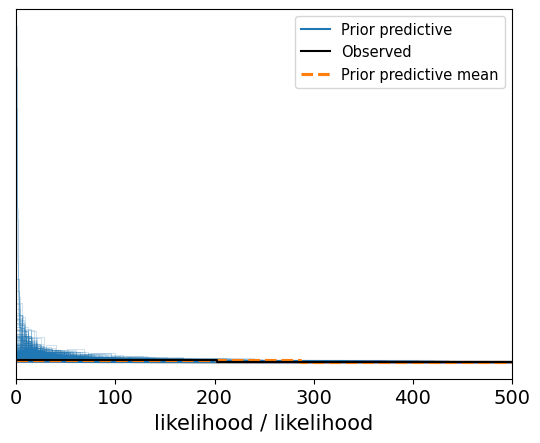

In [95]:
# Prior Predictive check to choose ? (15pt)
az.plot_ppc(trace, group='prior').set(xlim=[0, 500])

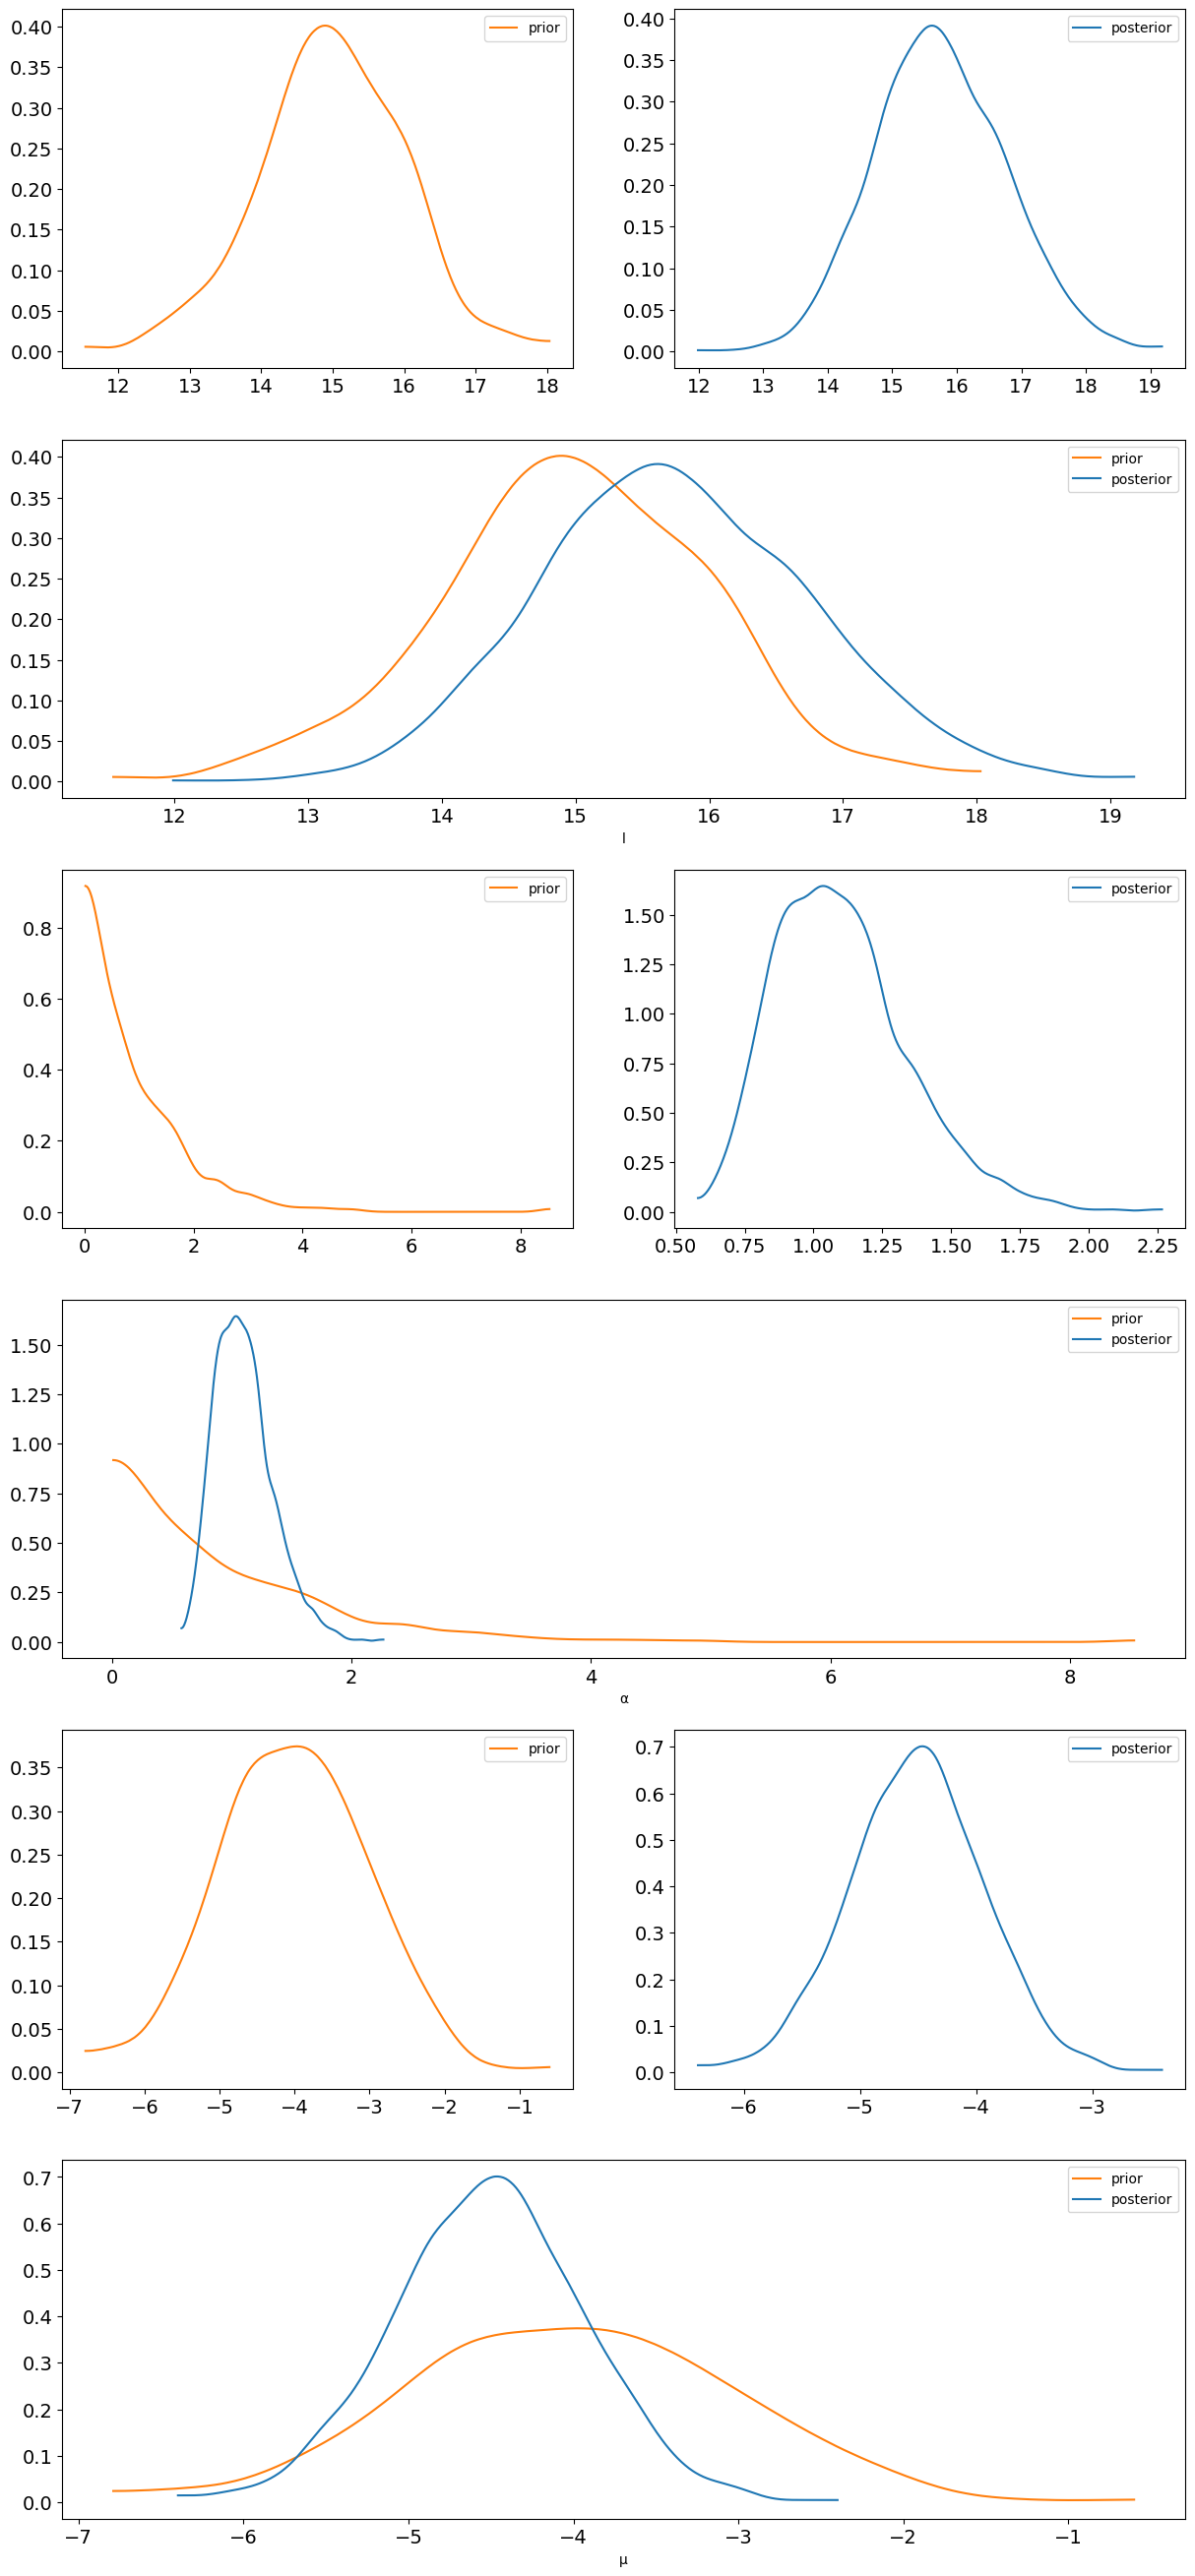

In [96]:
# Sampling and posterior vs prior plots az.plot_dist_comparison (5pt+5pt)
az.plot_dist_comparison(trace, var_names=['l', 'α', 'μ']);
plt.show()

<Axes: >

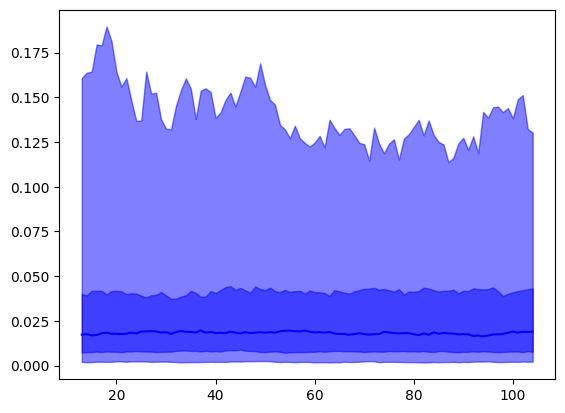

In [97]:
plot_quantile(trace.prior, 'p')

<Axes: >

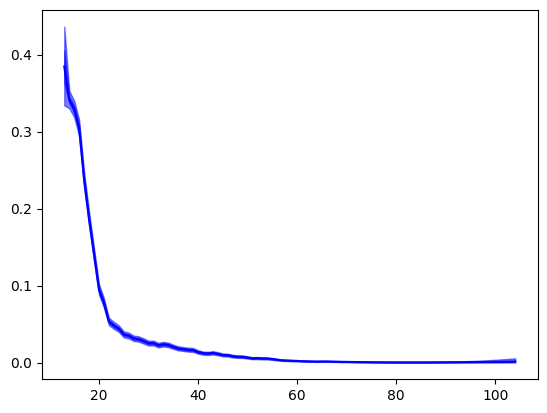

In [98]:
plot_quantile(trace.posterior, 'p')

<Axes: xlabel='age', ylabel='p'>

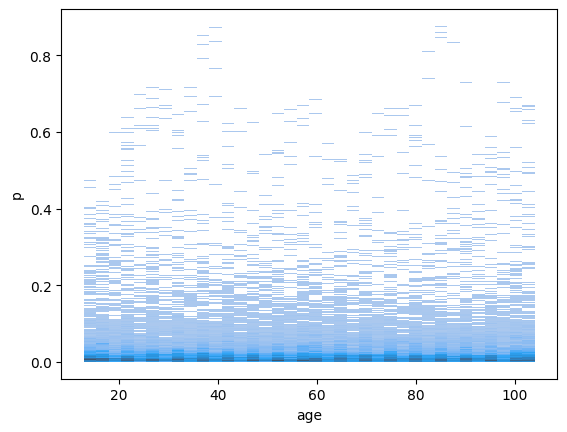

In [99]:
plot_histogram2d(trace.prior, 'p')

<Axes: xlabel='age', ylabel='p'>

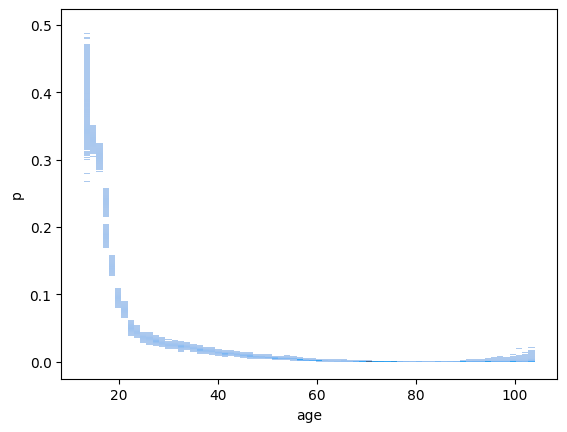

In [100]:
plot_histogram2d(trace.posterior, 'p')

## Model variant 2, another bonus (5pt)
You may notice, when age is close to 100y, the model misbehaves and shifts towards average. This behaviour is caused by the lack of structure, we did not tell we expect eldery not to take sports. In the next bonus model we explicitly condition model on the requirement to reduce activities when you are old. Mathematically, we say that at `age=110` probability to take sports is `sigmoid(-10)` and build a conditional GP

### Example
$$
\begin{align}
    k_a &\sim \operatorname{Binomial}(n_a, p_a)\\
    p_a & = \operatorname{sigmoid}(\tilde p_a)\\
    \tilde p_a &\sim \mathcal{GP}(\mu_{const}, K(.,.)\color{red}{\;|\; \tilde p_{110}=-10})\\
    K(.,.)&=\operatorname{cov.Exponential}(\operatorname{ls}=l) \cdot \alpha\\
    l&\sim \operatorname{Gamma}(?, ?)\\
    \alpha&\sim \operatorname{Exponential}(?)\\
    \mu_{const} &\sim \operatorname{Normal}(?, ?)
\end{align}
$$

```python
gp.conditinal(name, X, givens=dict(X=np.array([[110]]), f=np.array([-10])))
```